In [29]:
import h5py
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.transform import resize
from Utils import *

In [30]:
n_bbox_aug = 10
bbox_expand = 1.3
bbox_size = 64
image_size = 54
color_channels = 3
pixel_depth = 255.0
N_digs = 4             # Max. number of digits that the CNN/RNN can classify at once
N_digs_max = 6         # Max. number in the dataset (length of longest house number)
N_tokens = 10 + 2
S_len = N_digs_max + 2

**Preprocess images**

In [31]:
def import_bboxes(path):
    path = data_dir + path
    mat = h5py.File(path + '/digitStruct.mat', 'r')
    dig = mat['digitStruct']
    bbox = dig['bbox']
    keys = dig[bbox[0, 0]].keys()
    data = {k: [] for k in keys}
    n_samples = bbox.shape[0]
    data['n_digits'] = [dig[bbox[i, 0]]['label'][()].shape[0] for i in range(n_samples)]
    for key in keys:
        res = []
        for i in range(n_samples):
            n_digs = data['n_digits'][i]
            ds = [dig[bbox[i, 0]][key][()][j, 0] for j in range(n_digs)]
            if n_digs != 1:
                ds = [int(mat[d][()][0, 0]) for d in ds]
            else:
                ds = [int(d) for d in ds]
            data[str(key)].append(ds)
    return n_samples, data
def import_images(path, n_images):
    path = data_dir + path
    images = []
    for i in range(1, n_images + 1):
        img = (ndimage.imread(path + '/' + str(i) + '.png').astype(float) - pixel_depth / 2) / pixel_depth
        images.append(img)
        if i % 10 == 0:
            sys_pr('\rImported image ' + str(i))
    print()
    return images

# Generates bounding-box-augmented samples for the given dataset, caching the results to disk.
# For the training data, we repeat the process n times, to increase the effective size of our dataset,
# and make the model more robust to changes in the location of the house number within the image.
# with augment=False, this generates cropped versions of the samples for the digit-recognition-only
# problem. This solution would require an extra preprocessing stage in practice, to detect and identify
# the location of the digits in the image more accurately than the 30% expanded bounding box
def preprocess_samples(n_samples, images, bboxes, augment=True, n_augmentations=n_bbox_aug):
    exp_fac = (bbox_expand - 1.0) / 2
    n_augs = n_augmentations if augment else 1
    new_n = n_samples * n_augs
    if augment:
        x_shifts = np.random.randint(0, bbox_size - image_size, new_n)
        y_shifts = np.random.randint(0, bbox_size - image_size, new_n)
    dataset = np.ndarray(shape=(new_n, image_size, image_size,
        color_channels), dtype=np.float32)
    labels = [np.zeros((new_n, N_digs + 1), dtype=np.int)] + \
             [np.zeros((new_n, 10), dtype=np.int)] + \
             [np.zeros((new_n, 11), dtype=np.int) for _ in range(N_digs - 1)]
    seq_labels = np.zeros((new_n, S_len, N_tokens))  # For each possible digit + blankstop
    seq_masks = np.zeros((new_n, S_len), dtype=np.int32)
    for i in range(n_samples):
        x_i = (i * n_augs)
        img = images[i]
        n_digits = bboxes['n_digits'][i]
        seq_masks[x_i:x_i + n_augs, range(n_digits + 2)] = 1
        
        top = min(bboxes['top'][i])
        left = min(bboxes['left'][i])
        bottom = max([bboxes['top'][i][j] + bboxes['height'][i][j] for j in range(n_digits)])
        right = max([bboxes['left'][i][j] + bboxes['width'][i][j] for j in range(n_digits)])
        if augment:
            height = bottom - top
            width = right - left
            top = int(round(max(0, top - (exp_fac * height))))
            left = int(round(max(0, left - (exp_fac * width))))
            bottom = int(round(max(0, bottom + (exp_fac * height))))
            right = int(round(max(0, right + (exp_fac * width))))
        
        img = img[top:bottom, left:right, :]
        img = resize(np.ascontiguousarray(img), (bbox_size, bbox_size) if augment else (image_size, image_size))

        if augment:
            for j in range(n_augs):
                x_i_ = x_i + j
                x_shift = x_shifts[x_i_]
                y_shift = y_shifts[x_i_]
                dataset[x_i_] = img[x_shift:x_shift + image_size, y_shift:y_shift + image_size]
        else:
            dataset[x_i] = img

        digs = bboxes['label'][i]
        for j in range(n_augs):
            x_i_ = x_i + j
            if n_digits <= N_digs: labels[0][x_i_][n_digits - 1] = 1   # 0 to (N_digs - 1) represent 1 to N_digs digits
            else:                  labels[0][x_i_][N_digs] = 1         # index=N_digs represents "more than N_digs" digits
            for k in range(1, N_digs + 1):
                if k > n_digits: labels[k][x_i_][10] = 1          # 10 represents 'blank'
                else:
                    dig = digs[k - 1]
                    if dig == 10:
                        dig = 0
                    labels[k][x_i_][dig] = 1                      # 0-9 represent digits 0-9
                    
        for j in range(S_len):
            dig_i = 11
            if j == 0:
                dig_i = 0
            elif j - 1 < n_digits:
                dig_i = digs[j - 1]
                if dig_i == 10:
                    dig_i = 0
                dig_i += 1
            seq_labels[x_i:x_i + n_augs, j, dig_i] = 1               # 1-10 represent digits 0-9, 0 = start, 11 = stop

        if i % 10 == 0:
            sys_pr('\rGenerated preprocessed image ' + str(i) + '      ')
    print()

    return dataset, labels, seq_labels, seq_masks

In [7]:
n_train, train_bboxes = import_bboxes('train')
n_test, test_bboxes = import_bboxes('test')
save_ld((n_train, train_bboxes), "train_bboxes")
save_ld((n_test, test_bboxes), "test_bboxes")
# n_train, train_bboxes = load_ld("train_bboxes")
# n_test, test_bboxes = load_ld("test_bboxes")

In [8]:
train_images = import_images('train', n_train)
test_images = import_images('test', n_test)
save_ld(train_images, "train_images")
save_ld(test_images, "test_images")
# train_images = load_ld("train_images")
# test_images = load_ld("test_images")

Imported image 40

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


Imported image 33400
Imported image 13060


In [9]:
train_set, train_labels, train_seqs, train_masks = preprocess_samples(n_train, train_images, train_bboxes)
save_ld((train_set, train_labels, train_seqs, train_masks), "train_set")
test_set, test_labels, test_seqs, test_masks = preprocess_samples(n_test, test_images, test_bboxes, n_augmentations=1)
save_ld((test_set, test_labels, test_seqs, test_masks), "test_set")
# train_set, train_labels, train_seqs, train_masks = load_ld("train_set")
# test_set, test_labels, test_seqs, test_masks = load_ld("test_set")

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Generated preprocessed image 33400      
Generated preprocessed image 13060      


**Check array shapes and plot some test images**

In [10]:
X_train, Y_train = train_set, train_labels
X_test, Y_test = test_set, test_labels
n_train, n_test = X_train.shape[0], X_test.shape[0]
X_train.shape, train_seqs.shape, train_masks.shape, [ls.shape for ls in Y_train], \
    X_test.shape, test_seqs.shape, test_masks.shape, [ls.shape for ls in Y_test]

((334020, 54, 54, 3),
 (334020, 8, 12),
 (334020, 8),
 [(334020, 5), (334020, 10), (334020, 11), (334020, 11), (334020, 11)],
 (13068, 54, 54, 3),
 (13068, 8, 12),
 (13068, 8),
 [(13068, 5), (13068, 10), (13068, 11), (13068, 11), (13068, 11)])

In [ ]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):
    assert len(images) == len(cls_true) == 9
    fig, axes = plt.subplots(3, 3)  # Create figure with sub-plots.
    if cls_pred is None:  # Adjust vertical spacing if we need to print ensemble and best-net.
        hspace = 0.3
    else:
        hspace = 0.6
    fig.set_size_inches(12, 8)
    fig.subplots_adjust(hspace=hspace, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        if smooth:  # Interpolation type.
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'
        ax.imshow(images[i, :, :, :],  # Plot image.
                  interpolation=interpolation)
        cls_true_name = cls_true[i]  # Name of the true class.
        if cls_pred is None:  # Show true and predicted classes.
            xlabel = "True: {0}".format(cls_true_name)
        else:  # Name of the predicted class.
            cbs_pred_name = cls_pred[i]
            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)
        ax.set_xlabel(xlabel)  # Show the classes as the label on the x-axis.
        ax.set_xticks([])  # Remove ticks from the plot.
        ax.set_yticks([])
    plt.show()  # Ensure the plot is shown correctly with multiple plots in a single Notebook cell.

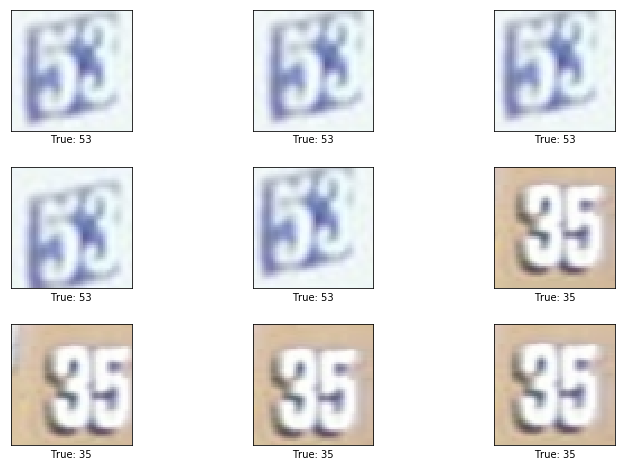

In [9]:
hns = []  # Get the actual house numbers for the test set
imgs, boxes = X_train, train_bboxes
for i in range(imgs.shape[0]):
    digs = boxes['label'][i // n_bbox_aug]
    digs = [d if d != 10 else 0 for d in digs]
    hns.append(int(''.join(str(d) for d in digs)))
hns = np.asarray(hns)
images = imgs[1005:1014] + 0.5
cls_true = hns[1005:1014]
plot_images(images=images, cls_true=cls_true, smooth=False)

**Shuffle training set**

In [11]:
def shuffle_data(data):
    indices = np.arange(data[0].shape[0]);
    np.random.shuffle(indices)
    return [d[indices] for d in data]
shuf = shuffle_data([X_train, train_seqs, train_masks] + Y_train)
X_train, train_seqs, train_masks, Y_train = shuf[0], shuf[1], shuf[2], shuf[3:]

**Define accuracy evaluation method**

In [12]:
def evaluate_predictions(Y, preds, masks, fail_long=False):  # Masks is included just to get the actual number of digits
    gt_cls, pr_cls = [], []
    for i in range(len(preds)):
        gt_cls.append(np.argmax(Y[i], axis=1))
        pr_cls.append(np.argmax(preds[i], axis=1))
    correct = 0
    digits_total = 0
    digits_correct = 0
    for i in range(preds[0].shape[0]):
        true_digs = sum(masks[i]) - 2

        # Since we're comparing two models with the same objective, we don't need the 'true' house number accuracy -
        # when there is a house number longer than N_digs, treat as if it is truncated to N_digs (default fail_long==False)

        n_digs = pr_cls[0][i] + 1
        n_act = gt_cls[0][i] + 1
        digits_total += min(n_act, N_digs)
        digits_correct += sum([gt_cls[j][i] == pr_cls[j][i] for j in range(1, min(n_act, N_digs) + 1)])
        if true_digs > N_digs:
            digits_total += true_digs - N_digs
            if not fail_long:
                digits_correct += true_digs - N_digs
            else:
                continue
        
        j = 1
        while True:
            gt_dig, pr_dig = gt_cls[j][i], pr_cls[j][i]
            if gt_dig != pr_dig:  # Incorrect digit
                break
            if j == N_digs:  # All specified digits up to the maximum house number length correct
                correct += 1
                break
            if j == n_act:  # If we've reached the end of the actual number
                if n_digs == n_act or pr_cls[j + 1][i] == 10:  # If the number of digits match or there is a blankstop
                    correct += 1
                break  # Otherwise, there are extra (incorrect) digits
            if j == n_digs:  # If we reach the end of the predicted sequence prematurely
                break
            j += 1
    return correct / preds[0].shape[0], digits_correct / digits_total
evaluate_predictions(Y_test, Y_test, test_masks), \
    evaluate_predictions(Y_test, Y_test, test_masks, fail_long=True), \
    evaluate_predictions(Y_test, [Y[:n_test] for Y in Y_train], train_masks[:n_test])

((1.0, 1.0),
 (0.9998469543924089, 0.9999231714812539),
 (0.009182736455463728, 0.11572882657960439))

**Train and test CNN**

In [13]:
import tensorflow as tf
from tensorflow.contrib.layers import maxout
from tensorflow.contrib import rnn
from tensorflow.nn import conv2d, max_pool, dropout, relu
from tensorflow.layers import batch_normalization as bnorm
from IPython.display import clear_output

In [ ]:
model_name = "cnn_model"
batch_size = 512
n_epochs = 30
learning_rate = 0.00012
# learning_rate_gd = 0.0001
dropout_keep_prob = 0.6
train_set_test_frac = 0.005  # Get training accuracy for random 5% subset of train set (~16k samples)
log_period_batches = 50

# Define next batch function
current_i, epochs_completed = 0, 0
def next_batch(b_size):
    global current_i, epochs_completed
    xs = X_train[current_i:current_i + b_size]
    ys = [Y[current_i:current_i + b_size] for Y in Y_train]
    current_i += b_size
    if current_i >= n_train:
        current_i = 0
        epochs_completed += 1
    return xs, ys

# Reset tensor graph
tf.reset_default_graph()
izer = tf.contrib.layers.xavier_initializer()
x = tf.placeholder(tf.float32, [None, image_size, image_size, color_channels])
ys = [tf.placeholder(tf.float32, [None, Y.shape[1]]) for Y in Y_train]
keep_p = tf.placeholder(tf.float32)
n_train_test = int(train_set_test_frac * n_train)
train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []
train_dig_accuracy, test_dig_accuracy = [], []

#####################################################
# Define model, loss, update and evaluation metric. #
#####################################################

s_1 = 48
s_2 = 64
s_3 = 128
s_4 = 160
s_5 = 192
l1_neurons = 3072
l2_neurons = 3072
l3_neurons = 3072
# l4_neurons = 3072
# l5_neurons = 3072

W1 = tf.Variable(izer((5, 5, color_channels, s_1)))
#b1 = tf.Variable(izer((image_size, image_size, s_1)))
W2 = tf.Variable(izer((5, 5, s_1 // 3, s_2)))
#b2 = tf.Variable(izer((27, 27, s_2)))
W3 = tf.Variable(izer((5, 5, s_2, s_3)))
#b3 = tf.Variable(izer((27, 27, s_3)))
W4 = tf.Variable(izer((5, 5, s_3, s_4)))
#b4 = tf.Variable(izer((14, 14, s_4)))
W5 = tf.Variable(izer((5, 5, s_4, s_5)))
#b5 = tf.Variable(izer((14, 14, s_5)))
W6 = tf.Variable(izer((5, 5, s_5, s_5)))
#b6 = tf.Variable(izer((7, 7, s_5)))
W7 = tf.Variable(izer((5, 5, s_5, s_5)))
#b7 = tf.Variable(izer((7, 7, s_5)))
W8 = tf.Variable(izer((5, 5, s_5, s_5)))
#b8 = tf.Variable(izer((4, 4, s_5)))
# conv_output_neurons = 14 * 14 * s_4
# conv_output_neurons = 7 * 7 * s_5
conv_output_neurons = 4 * 4 * s_5
Wl1 = tf.Variable(izer((conv_output_neurons, l1_neurons)))
bl1 = tf.Variable(izer((l1_neurons,)))
Wl2 = tf.Variable(izer((l1_neurons, l2_neurons)))
bl2 = tf.Variable(izer((l2_neurons,)))
Wl3 = tf.Variable(izer((l2_neurons, l3_neurons)))
bl3 = tf.Variable(izer((l3_neurons,)))
# Wl4 = tf.Variable(izer((l3_neurons, l4_neurons)))
# bl4 = tf.Variable(izer((l4_neurons,)))
# Wl5 = tf.Variable(izer((l4_neurons, l5_neurons)))
# bl5 = tf.Variable(izer((l5_neurons,)))
Y_W1s = [tf.Variable(izer([l3_neurons, Y_train[i].shape[1]])) for i in range(len(Y_train))]
Y_b1s = [tf.Variable(izer([Y_train[i].shape[1]])) for i in range(len(Y_train))]

conv_1 = conv2d(x, W1, strides=[1, 1, 1, 1], padding='SAME')# + b1
# maxpool_1 = bnorm(maxout(max_pool(conv_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'), s_1 // 3))
maxpool_1 = bnorm(dropout(maxout(max_pool(conv_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'), s_1 // 3), keep_p))
conv_2 = conv2d(maxpool_1, W2, strides=[1, 1, 1, 1], padding='SAME')# + b2
# maxpool_2 = bnorm(relu(max_pool(conv_2, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')))
maxpool_2 = bnorm(dropout(relu(max_pool(conv_2, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')), keep_p))
conv_3 = conv2d(maxpool_2, W3, strides=[1, 1, 1, 1], padding='SAME')# + b3
# maxpool_3 = bnorm(relu(max_pool(conv_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')))
maxpool_3 = bnorm(dropout(relu(max_pool(conv_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')), keep_p))
conv_4 = conv2d(maxpool_3, W4, strides=[1, 1, 1, 1], padding='SAME')# + b4
# maxpool_4 = bnorm(relu(max_pool(conv_4, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')))
maxpool_4 = bnorm(dropout(relu(max_pool(conv_4, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')), keep_p))
conv_5 = conv2d(maxpool_4, W5, strides=[1, 1, 1, 1], padding='SAME')# + b5
# maxpool_5 = bnorm(relu(max_pool(conv_5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')))
maxpool_5 = bnorm(dropout(relu(max_pool(conv_5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')), keep_p))
conv_6 = conv2d(maxpool_5, W6, strides=[1, 1, 1, 1], padding='SAME')# + b6
# maxpool_6 = bnorm(relu(max_pool(conv_6, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')))
maxpool_6 = bnorm(dropout(relu(max_pool(conv_6, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')), keep_p))
conv_7 = conv2d(maxpool_6, W7, strides=[1, 1, 1, 1], padding='SAME')# + b7
# maxpool_7 = bnorm(relu(max_pool(conv_7, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')))
maxpool_7 = bnorm(dropout(relu(max_pool(conv_7, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')), keep_p))
conv_8 = conv2d(maxpool_7, W8, strides=[1, 1, 1, 1], padding='SAME')# + b8
# maxpool_8 = bnorm(relu(max_pool(conv_8, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')))
maxpool_8 = bnorm(dropout(relu(max_pool(conv_8, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')), keep_p))

flattened = tf.reshape(maxpool_8, [-1, conv_output_neurons]) # Flatten
# llayer_1 = dropout(tf.matmul(flattened, Wl1) + bl1, keep_p)
# llayer_2 = dropout(tf.matmul(llayer_1, Wl2) + bl2, keep_p)
llayer_1 = bnorm(dropout(tf.matmul(flattened, Wl1) + bl1, keep_p))
llayer_2 = bnorm(dropout(tf.matmul(llayer_1, Wl2) + bl2, keep_p))
llayer_3 = bnorm(dropout(tf.matmul(llayer_2, Wl3) + bl3, keep_p))
# llayer_4 = bnorm(dropout(tf.matmul(llayer_3, Wl4) + bl4, keep_p))
# llayer_5 = bnorm(dropout(tf.matmul(llayer_4, Wl5) + bl5, keep_p))
Y_outs = [tf.matmul(llayer_3, Y_W1s[i]) + Y_b1s[i] for i in range(len(Y_train))]

# Define loss and training step
Y_losses = [tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
             labels=ys[i], logits=Y_outs[i])) for i in range(len(Y_train))]
loss = sum(Y_losses)
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
# train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate_gd).minimize(loss)

# Define basic accuracy computation (actual house number accuracy is done later)
accuracy = sum([tf.reduce_mean(tf.cast(tf.equal(tf.argmax(
    Y_outs[i], 1), tf.argmax(ys[i], 1)), tf.float32)) for i in range(len(Y_train))]) / len(Y_train)

# Train
batch_i = 0
best_acc = 0
saver = tf.train.Saver()

Training accuracy [House numbers, digits], Testing accuracy [House numbers, digits],Training loss, Testing loss
Epoch 30 : 1.0 1.0 0.9004 0.9424 0.0038 0.8965  Best test acc [house number, digits]: 0.9059 0.9447


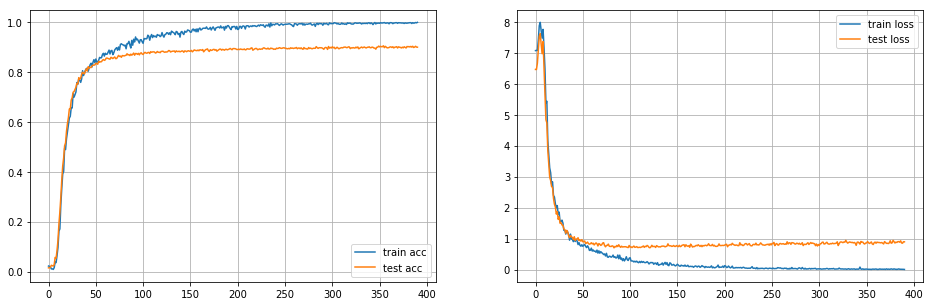

Batch 19549 complete


In [18]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    while epochs_completed < n_epochs:
        
        batch_i += 1
        batch_xs, batch_ys = next_batch(batch_size)
        ys_feed = {ys[i]: batch_ys[i] for i in range(len(Y_train))}
        sess.run(train_step, feed_dict={**ys_feed,**{x: batch_xs, keep_p: dropout_keep_prob}})
        sys_pr('\rBatch '+ str(batch_i) + ' complete')

        if batch_i % log_period_batches == 0:

            # Get random sample of 5% of the training dataset
            indices = np.random.choice(n_train, n_train_test, replace=False)
            n_train_test_batch = 256
            train_ls, train_as, train_as_alt = [], [], []
            for j in range(n_train_test // n_train_test_batch):
                o = j * n_train_test_batch
                Ys = [Y_train[i][indices][o:o + n_train_test_batch] for i in range(len(Y_train))]
                ys_feed = {ys[i]: Ys[i] for i in range(len(Y_train))}
                train_l, y_outs = sess.run([loss, Y_outs], feed_dict={**ys_feed,**{
                                                              x: X_train[indices][o:o + n_train_test_batch], keep_p: 1.0}})
                train_ls.append(train_l)
                a, dig_a = evaluate_predictions(Ys, y_outs, train_masks[indices][o:o + n_train_test_batch])
                train_as.append(a)
                train_as_alt.append(dig_a)

            n_test_batch = 256
            test_ls, test_as, test_as_alt = [], [], []
            for j in range(n_test // n_test_batch):
                o = j * n_test_batch
                Ys = [Y_test[i][o:o + n_test_batch] for i in range(len(Y_test))]
                ys_feed = {ys[i]: Ys[i] for i in range(len(Y_test))}
                test_l, y_outs = sess.run([loss, Y_outs], feed_dict={**ys_feed,**{
                                                            x: X_test[o:o + n_test_batch], keep_p: 1.0}})
                test_ls.append(test_l)
                a, dig_a = evaluate_predictions(Ys, y_outs, test_masks[o:o + n_test_batch])
                test_as.append(a)
                test_as_alt.append(dig_a)

            train_a, train_l = np.mean(train_as), np.mean(train_ls)
            test_a, test_l = np.mean(test_as), np.mean(test_ls)
            train_a_alt, test_a_alt = np.mean(train_as_alt), np.mean(test_as_alt)
            train_loss += [ train_l ]
            train_accuracy += [ train_a ]
            train_dig_accuracy += [ train_a_alt ]
            test_loss += [ test_l ]
            test_accuracy += [ test_a ]
            test_dig_accuracy += [ test_a_alt ]
            
            create_folder("models")
            create_folder("models/" + model_name)
            if test_a > best_acc:
                best_acc = test_a
                saver.save(sess, "./models/" + model_name + '/' + model_name)
                
            clear_output()
            print("Training accuracy [House numbers, digits], Testing accuracy [House numbers, digits]," + \
                  "Training loss, Testing loss")
            print("Epoch", epochs_completed, ':',
                  round(train_a, 4), round(train_a_alt, 4),
                  round(test_a, 4), round(test_a_alt, 4),
                  round(train_l, 4), round(test_l, 4),
                  " Best test acc [house number, digits]:", round(best_acc, 4), round(max(test_dig_accuracy), 4)
            fig = plt.figure()
            fig.set_size_inches(16, 5)
            g = fig.add_subplot(1,2,1)
            g.grid()
            g.plot(train_accuracy, label='train acc')
            g.plot(test_accuracy, label='test acc')
            g.legend(loc='lower right')
    
            g = fig.add_subplot(1,2,2)
            g.grid()
            g.plot(train_loss, label='train loss')
            g.plot(test_loss, label='test loss')
            g.legend(loc='upper right')

            save_ld((train_accuracy, train_dig_accuracy, test_accuracy, test_dig_accuracy, train_loss, test_loss),
                    "models/" + model_name + '_log.data')
            graphs_folder = "graphs"
            create_folder(graphs_folder)
            plt.savefig(graphs_folder + '/' + model_name + "_curve" + '.pdf', format='pdf')
            plt.show()

Load & test trained CNN

In [15]:
with tf.Session() as sess:
    saver.restore(sess, "./models/cnn_model/cnn_model")

    # Get random sample of 10% of the training dataset
    indices = np.random.choice(n_train, n_train_test, replace=False)
    n_train_test_batch = 256
    train_ls, train_as, train_as_alt = [], [], []
    for j in range(n_train_test // n_train_test_batch):
        o = j * n_train_test_batch
        Ys = [Y_train[i][indices][o:o + n_train_test_batch] for i in range(len(Y_train))]
        ys_feed = {ys[i]: Ys[i] for i in range(len(Y_train))}
        train_l, y_outs = sess.run([loss, Y_outs], feed_dict={**ys_feed,**{
                                                      x: X_train[indices][o:o + n_train_test_batch], keep_p: 1.0}})
        train_ls.append(train_l)
        a, dig_a = evaluate_predictions(Ys, y_outs, train_masks[indices][o:o + n_train_test_batch])
        train_as.append(a)
        train_as_alt.append(dig_a)

    n_test_batch = 256
    test_ls, test_as, test_as_alt = [], [], []
    for j in range(n_test // n_test_batch):
        o = j * n_test_batch
        Ys = [Y_test[i][o:o + n_test_batch] for i in range(len(Y_test))]
        ys_feed = {ys[i]: Ys[i] for i in range(len(Y_test))}
        test_l, y_outs = sess.run([loss, Y_outs], feed_dict={**ys_feed,**{
                                                    x: X_test[o:o + n_test_batch], keep_p: 1.0}})
        test_ls.append(test_l)
        a, dig_a = evaluate_predictions(Ys, y_outs, test_masks[o:o + n_test_batch])
        test_as.append(a)
        test_as_alt.append(dig_a)

    train_a, train_l = np.mean(train_as), np.mean(train_ls)
    test_a, test_l = np.mean(test_as), np.mean(test_ls)
    train_a_alt, test_a_alt = np.mean(train_as_alt), np.mean(test_as_alt)

    print("Results:", train_a, train_a_alt, test_a, test_a_alt, train_l, test_l)

**Train and test RNN**

In [16]:
model_name = "rnn_model"
batch_size = 512
n_epochs = 30
learning_rate = 0.0001
# learning_rate_gd = 0.0001
dropout_keep_prob = 0.6
rnn_keep_prob = 0.7
train_set_test_frac = 0.005  # Get training accuracy for random 5% subset of train set (~16k samples)
log_period_batches = 100

# Define next batch function
current_i, epochs_completed = 0, 0
def next_batch(b_size):
    global current_i, epochs_completed
    xs = X_train[current_i:current_i + b_size]
    ys = [Y[current_i:current_i + b_size] for Y in Y_train]
    current_i += b_size
    if current_i >= n_train:
        current_i = 0
        epochs_completed += 1
    return xs, ys

# Reset tensor graph
tf.reset_default_graph()
izer = tf.contrib.layers.xavier_initializer()
x = tf.placeholder(tf.float32, [None, image_size, image_size, color_channels])
ys = [tf.placeholder(tf.float32, [None, Y.shape[1]]) for Y in Y_train]
keep_p = tf.placeholder(tf.float32)
rnn_keep_p = tf.placeholder(tf.float32)
n_train_test = int(train_set_test_frac * n_train)
train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []
train_dig_accuracy, test_dig_accuracy = [], []

#####################################################
# Define model, loss, update and evaluation metric. #
#####################################################

input_size = image_size * color_channels
pre1_units = 256
n_rnn_units = 512
post1_units = 2048
post2_units = 2048
n_rnn_stacked = 1
lstm_forget_bias = 1.0
c_type = "LSTM"

W_1 = tf.Variable(izer([input_size , pre1_units]))
b_1 = tf.Variable(izer([pre1_units]))
Wl1 = tf.Variable(izer([n_rnn_units , post1_units]))
bl1 = tf.Variable(izer([post1_units]))
Wl2 = tf.Variable(izer([post1_units , post2_units]))
bl2 = tf.Variable(izer([post2_units]))
Y_W1s = [tf.Variable(izer([post2_units, Y_train[i].shape[1]])) for i in range(len(Y_train))]
Y_b1s = [tf.Variable(izer([Y_train[i].shape[1]])) for i in range(len(Y_train))]

def get_rnn_cell(c_type, lstm_forget_bias, keep_prob):
  cell = rnn.GRUCell(n_rnn_units) if c_type == "GRU" else \
         rnn.LSTMCell(n_rnn_units, forget_bias=lstm_forget_bias)
  return rnn.DropoutWrapper(cell, input_keep_prob=1.0, output_keep_prob=keep_prob)
cell = rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_keep_p) for _ in range(n_rnn_stacked)]) if \
    n_rnn_stacked > 1 else get_rnn_cell(c_type, lstm_forget_bias, rnn_keep_p)

b_size = tf.shape(x)[0]
x_inp = tf.reshape(tf.transpose(x, [0, 2, 1, 3]), [b_size * image_size, input_size])  # Lead with column index (l2r scan)
pre1_layer = tf.reshape(bnorm(tf.matmul(x_inp, W_1) + b_1), [b_size, image_size, pre1_units])
rnn_output, _ = tf.nn.dynamic_rnn(cell, pre1_layer, dtype=tf.float32)
post1_layer = bnorm(tf.matmul(rnn_output[:, -1], Wl1) + bl1)
post2_layer = bnorm(tf.matmul(post1_layer, Wl2) + bl2)
Y_outs = [tf.matmul(post2_layer, Y_W1s[i]) + Y_b1s[i] for i in range(len(Y_train))]

# Define loss and training step
Y_losses = [tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
             labels=ys[i], logits=Y_outs[i])) for i in range(len(Y_train))]
loss = sum(Y_losses)
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
# train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate_gd).minimize(loss)

# Define basic accuracy computation (actual house number accuracy is done later)
accuracy = sum([tf.reduce_mean(tf.cast(tf.equal(tf.argmax(
    Y_outs[i], 1), tf.argmax(ys[i], 1)), tf.float32)) for i in range(len(Y_train))]) / len(Y_train)

# Train
batch_i = 0
best_acc = 0
saver = tf.train.Saver()

In [28]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    while epochs_completed < n_epochs:
        
        batch_i += 1
        batch_xs, batch_ys = next_batch(batch_size)
        ys_feed = {ys[i]: batch_ys[i] for i in range(len(Y_train))}
        sess.run(train_step, feed_dict={**ys_feed,**{x: batch_xs, keep_p: dropout_keep_prob, rnn_keep_p: rnn_keep_prob}})
        sys_pr('\rBatch '+ str(batch_i) + ' complete')

        if batch_i % log_period_batches == 0:

            # Get random sample of 5% of the training dataset
            indices = np.random.choice(n_train, n_train_test, replace=False)
            n_train_test_batch = 256
            train_ls, train_as, train_as_alt = [], [], []
            for j in range(n_train_test // n_train_test_batch):
                o = j * n_train_test_batch
                Ys = [Y_train[i][indices][o:o + n_train_test_batch] for i in range(len(Y_train))]
                ys_feed = {ys[i]: Ys[i] for i in range(len(Y_train))}
                train_l, y_outs = sess.run([loss, Y_outs], feed_dict={**ys_feed,**{
                    x: X_train[indices][o:o + n_train_test_batch], keep_p: 1.0, rnn_keep_p: 1.0}})
                train_ls.append(train_l)
                a, dig_a = evaluate_predictions(Ys, y_outs, train_masks[indices][o:o + n_train_test_batch])
                train_as.append(a)
                train_as_alt.append(dig_a)

            n_test_batch = 256
            test_ls, test_as, test_as_alt = [], [], []
            for j in range(n_test // n_test_batch):
                o = j * n_test_batch
                Ys = [Y_test[i][o:o + n_test_batch] for i in range(len(Y_test))]
                ys_feed = {ys[i]: Ys[i] for i in range(len(Y_test))}
                test_l, y_outs = sess.run([loss, Y_outs], feed_dict={**ys_feed,**{
                    x: X_test[o:o + n_test_batch], keep_p: 1.0, rnn_keep_p: 1.0}})
                test_ls.append(test_l)
                a, dig_a = evaluate_predictions(Ys, y_outs, test_masks[o:o + n_test_batch])
                test_as.append(a)
                test_as_alt.append(dig_a)

            train_a, train_l = np.mean(train_as), np.mean(train_ls)
            test_a, test_l = np.mean(test_as), np.mean(test_ls)
            train_a_alt, test_a_alt = np.mean(train_as_alt), np.mean(test_as_alt)
            train_loss += [ train_l ]
            train_accuracy += [ train_a ]
            train_dig_accuracy += [ train_a_alt ]
            test_loss += [ test_l ]
            test_accuracy += [ test_a ]
            test_dig_accuracy += [ test_a_alt ]

            if test_a > best_acc:
                best_acc = test_a
                create_folder("models")
                create_folder("models/" + model_name)
                saver.save(sess, "./models/" + model_name + '/' + model_name)
                
            clear_output()
            print("Training accuracy [House numbers, digits], Testing accuracy [House numbers, digits]," + \
                  "Training loss, Testing loss")
            print("Epoch", epochs_completed, ':',
                  round(train_a, 4), round(train_a_alt, 4),
                  round(test_a, 4), round(test_a_alt, 4),
                  round(train_l, 4), round(test_l, 4),
                  " Best test acc [house number, digits]:", round(best_acc, 4), round(max(test_dig_accuracy), 4)
            fig = plt.figure()
            fig.set_size_inches(16, 5)
            g = fig.add_subplot(1,2,1)
            g.grid()
            g.plot(train_accuracy, label='train acc')
            g.plot(test_accuracy, label='test acc')
            g.legend(loc='lower right')
    
            g = fig.add_subplot(1,2,2)
            g.grid()
            g.plot(train_loss, label='train loss')
            g.plot(test_loss, label='test loss')
            g.legend(loc='upper right')

            save_ld((train_accuracy, train_dig_accuracy, test_accuracy, test_dig_accuracy, train_loss, test_loss),
                    model_name + '_log')
            graphs_folder = "graphs"
            create_folder(graphs_folder)
            plt.savefig(graphs_folder + '/' + model_name + "_curve" + '.pdf', format='pdf')
            plt.show()

Training accuracy [House numbers, digits], Testing accuracy [House numbers, digits],Training loss, Testing loss
Epoch 29 : 0.9655 0.9825 0.651 0.7737 0.1173 4.0563  Best test acc [house number, digits]: 0.6518 0.7737


Batch 19590 complete


Load & test trained RNN

In [15]:
with tf.Session() as sess:
    saver.restore(sess, "./models/" + model_name + '/' + model_name)

    # Get random sample of 10% of the training dataset
    indices = np.random.choice(n_train, n_train_test, replace=False)
    n_train_test_batch = 256
    train_ls, train_as, train_as_alt = [], [], []
    for j in range(n_train_test // n_train_test_batch):
        o = j * n_train_test_batch
        Ys = [Y_train[i][indices][o:o + n_train_test_batch] for i in range(len(Y_train))]
        ys_feed = {ys[i]: Ys[i] for i in range(len(Y_train))}
        train_l, y_outs = sess.run([loss, Y_outs], feed_dict={**ys_feed,**{
                                                      x: X_train[indices][o:o + n_train_test_batch], keep_p: 1.0}})
        train_ls.append(train_l)
        a, dig_a = evaluate_predictions(Ys, y_outs, train_masks[indices][o:o + n_train_test_batch])
        train_as.append(a)
        train_as_alt.append(dig_a)

    n_test_batch = 256
    test_ls, test_as, test_as_alt = [], [], []
    for j in range(n_test // n_test_batch):
        o = j * n_test_batch
        Ys = [Y_test[i][o:o + n_test_batch] for i in range(len(Y_test))]
        ys_feed = {ys[i]: Ys[i] for i in range(len(Y_test))}
        test_l, y_outs = sess.run([loss, Y_outs], feed_dict={**ys_feed,**{
                                                    x: X_test[o:o + n_test_batch], keep_p: 1.0}})
        test_ls.append(test_l)
        a, dig_a = evaluate_predictions(Ys, y_outs, test_masks[o:o + n_test_batch])
        test_as.append(a)
        test_as_alt.append(dig_a)

    train_a, train_l = np.mean(train_as), np.mean(train_ls)
    test_a, test_l = np.mean(test_as), np.mean(test_ls)
    train_a_alt, test_a_alt = np.mean(train_as_alt), np.mean(test_as_alt)

    print("Results:", train_a, train_a_alt, test_a, test_a_alt, train_l, test_l)

CNN with RNN sequence output layer (attempt)

In [40]:
batch_size = 128
n_epochs = 30
learning_rate = 0.001
# learning_rate_gd = 0.01
dropout_kp = 0.6
rnn_dropout_kp = 0.7
train_set_test_frac = 0.005  # Get training accuracy for random 5% subset of train set (~16k samples)
log_period_batches = 50

# Define next batch function
current_i, epochs_completed = 0, 0
def next_batch(b_size):
    global current_i, epochs_completed
    xs = X_train[current_i:current_i + b_size]
    ys = train_seqs[current_i:current_i + b_size]
    mks = train_masks[current_i:current_i + b_size]
    current_i += b_size
    if current_i >= n_train:
        current_i = 0
        epochs_completed += 1
    return xs, ys, mks

# Reset tensor graph
tf.reset_default_graph()
izer = tf.contrib.layers.xavier_initializer()
# izer = tf.random_uniform_initializer(
#             minval=-0.08,
#             maxval=0.08)
x = tf.placeholder(tf.float32, [None, image_size, image_size, color_channels])
y = tf.placeholder(tf.float32, [None, S_len, N_tokens])
seq_mask = tf.placeholder(tf.int32, [None, S_len])
keep_p = tf.placeholder(tf.float32)
rnn_keep_p = tf.placeholder(tf.float32)
n_train_test = int(train_set_test_frac * n_train)
train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []

#####################################################
# Define model, loss, update and evaluation metric. #
#####################################################

s_1 = 48   # Hyperparameters
s_2 = 64 
s_3 = 128
s_4 = 160
s_5 = 192
l1_neurons = 3072
l2_neurons = 3072
# l3_neurons = 3072

emb_features = 512
n_rnn_units = 256
lstm_forget_bias = 1.0
n_rnn_stacked = 1
c_type = "GRU"

W1 = tf.Variable(izer((5, 5, color_channels, s_1)))   # Variables
W2 = tf.Variable(izer((5, 5, s_1 // 3, s_2)))
W3 = tf.Variable(izer((5, 5, s_2, s_3)))
W4 = tf.Variable(izer((5, 5, s_3, s_4)))
W5 = tf.Variable(izer((5, 5, s_4, s_5)))
W6 = tf.Variable(izer((5, 5, s_5, s_5)))
W7 = tf.Variable(izer((5, 5, s_5, s_5)))
W8 = tf.Variable(izer((5, 5, s_5, s_5)))
conv_output_neurons = 4 * 4 * s_5
Wl1 = tf.Variable(izer((conv_output_neurons, l1_neurons)))
bl1 = tf.Variable(izer((l1_neurons,)))
Wl2 = tf.Variable(izer((l1_neurons, l2_neurons)))
bl2 = tf.Variable(izer((l2_neurons,)))
Wl3 = tf.Variable(izer((l2_neurons, emb_features)))
bl3 = tf.Variable(izer((emb_features,)))
# Wl4 = tf.Variable(izer([l3_neurons, emb_features]))
# bl4 = tf.Variable(izer([emb_features]))
W_emb = tf.Variable(izer([1, 1, emb_features]))   # Dont include the end token as a sequence input
W_out = tf.Variable(izer([n_rnn_units, N_tokens - 1]))   # Don't include the start token as a possible output
# b_out = tf.Variable(izer([N_tokens - 1]))

conv_1 = conv2d(x, W1, strides=[1, 1, 1, 1], padding='SAME')   # Network
maxpool_1 = bnorm(dropout(maxout(max_pool(conv_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'), s_1 // 3), keep_p))
conv_2 = conv2d(maxpool_1, W2, strides=[1, 1, 1, 1], padding='SAME')
maxpool_2 = bnorm(dropout(relu(max_pool(conv_2, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')), keep_p))
conv_3 = conv2d(maxpool_2, W3, strides=[1, 1, 1, 1], padding='SAME')
maxpool_3 = bnorm(dropout(relu(max_pool(conv_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')), keep_p))
conv_4 = conv2d(maxpool_3, W4, strides=[1, 1, 1, 1], padding='SAME')
maxpool_4 = bnorm(dropout(relu(max_pool(conv_4, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')), keep_p))
conv_5 = conv2d(maxpool_4, W5, strides=[1, 1, 1, 1], padding='SAME')
maxpool_5 = bnorm(dropout(relu(max_pool(conv_5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')), keep_p))
conv_6 = conv2d(maxpool_5, W6, strides=[1, 1, 1, 1], padding='SAME')
maxpool_6 = bnorm(dropout(relu(max_pool(conv_6, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')), keep_p))
conv_7 = conv2d(maxpool_6, W7, strides=[1, 1, 1, 1], padding='SAME')
maxpool_7 = bnorm(dropout(relu(max_pool(conv_7, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')), keep_p))
conv_8 = conv2d(maxpool_7, W8, strides=[1, 1, 1, 1], padding='SAME')
maxpool_8 = bnorm(dropout(relu(max_pool(conv_8, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')), keep_p))

flattened = tf.reshape(maxpool_8, [-1, conv_output_neurons])
llayer_1 = relu(bnorm(tf.matmul(flattened, Wl1) + bl1))
llayer_2 = relu(bnorm(tf.matmul(llayer_1, Wl2) + bl2))
llayer_3 = tf.matmul(llayer_2, Wl3) + bl3
# llayer_4 = bnorm(dropout(tf.matmul(llayer_3, Wl4) + bl4, keep_p))

def get_rnn_cell(c_type, lstm_forget_bias, keep_prob):
  cell = rnn.GRUCell(n_rnn_units) if c_type == "GRU" else \
         rnn.LSTMCell(n_rnn_units, state_is_tuple=True, forget_bias=lstm_forget_bias)
  return rnn.DropoutWrapper(cell, input_keep_prob=1.0, output_keep_prob=keep_prob)
cell = rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, rnn_keep_p) for _ in range(n_rnn_stacked)]) if \
    n_rnn_stacked > 1 else get_rnn_cell(c_type, lstm_forget_bias, rnn_keep_p)

seq_len = tf.reduce_sum(seq_mask[:, 1:], 1)
b_size = tf.shape(x)[0]
zero_state = cell.zero_state(batch_size=b_size, dtype=tf.float32)
_, init_state = cell(llayer_3, zero_state)

seq_inp = tf.tile(W_emb, [b_size, S_len - 1, 1])
rnn_output, _ = tf.nn.dynamic_rnn(cell, seq_inp, initial_state=init_state, dtype=tf.float32)
output = tf.reshape(rnn_output, [-1, cell.output_size])

logits = tf.matmul(output, W_out)# + b_out
labels = tf.argmax(tf.reshape(y[:, 1:, 1:], [-1, N_tokens - 1]), 1)  # Output target sequence (ignore start flag)
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)

weights = tf.to_float(tf.reshape(seq_mask[:, 1:], [-1]))
loss = tf.div(tf.reduce_sum(tf.multiply(losses, weights)), tf.reduce_sum(weights))
accuracy = tf.reduce_mean(tf.cast(tf.reduce_all(tf.cast(tf.constant(1.0) - tf.reshape(tf.cast(
    tf.not_equal(tf.argmax(logits, 1), labels), tf.float32) * weights, [-1, S_len - 1]), tf.bool), 1), tf.float32))

train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
# train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate_gd).minimize(loss)

# Train
batch_i = 0
best_acc = 0
saver = tf.train.Saver()

In [41]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    while epochs_completed < n_epochs:
        
        batch_i += 1
        batch_xs, batch_ys, batch_mks = next_batch(batch_size)
        sess.run(train_step, feed_dict={x: batch_xs, y: batch_ys, seq_mask: batch_mks,
                                        keep_p: dropout_kp, rnn_keep_p: rnn_dropout_kp})
        sys_pr('\rBatch '+ str(batch_i) + ' complete')

        if batch_i % log_period_batches == 0:

            # Get random sample of 10% of the training dataset
            indices = np.random.choice(n_train, n_train_test, replace=False)
            n_train_test_batch = 256
            train_ls, train_as = [], []
            for j in range(n_train_test // n_train_test_batch):
                o = j * n_train_test_batch
                train_l, train_a = sess.run([loss, accuracy], feed_dict={
                    x: X_train[indices][o:o + n_train_test_batch],
                    y: train_seqs[indices][o:o + n_train_test_batch],
                    seq_mask: train_masks[indices][o:o + n_train_test_batch],
                    keep_p: 1.0, rnn_keep_p: rnn_dropout_kp})
                train_ls.append(train_l)
                train_as.append(train_a)

            n_test_batch = 256
            test_ls, test_as = [], []
            for j in range(n_test // n_test_batch):
                o = j * n_test_batch
                test_l, test_a = sess.run([loss, accuracy], feed_dict={
                    x: X_test[o:o + n_test_batch],
                    y: test_seqs[o:o + n_test_batch],
                    seq_mask: test_masks[o:o + n_test_batch],
                    keep_p: 1.0, rnn_keep_p: 1.0})
                test_ls.append(test_l)
                test_as.append(test_a)

            train_a, train_l = np.mean(train_as), np.mean(train_ls)
            test_a, test_l = np.mean(test_as), np.mean(test_ls)
            train_loss += [ train_l ]
            train_accuracy += [ train_a ]
            test_loss += [ test_l ]
            test_accuracy += [ test_a ]
            
            if test_a > best_acc:
                best_acc = test_a
                dir_name = "cnnrnn_model"
                create_folder("models")
                create_folder("models/" + dir_name)
                saver.save(sess, "./models/" + dir_name + '/' + dir_name)
                
            clear_output()
            print("Epoch", epochs_completed, ':',
                  round(train_a, 4), round(test_a, 4), round(train_l, 4), round(test_l, 4),
                  " Best test acc:", round(best_acc, 4))
            fig = plt.figure()
            fig.set_size_inches(16, 5)
            g = fig.add_subplot(1,2,1)
            g.grid()
            g.plot(train_accuracy, label='train acc')
            g.plot(test_accuracy, label='test acc')
            g.legend(loc='lower right')
    
            g = fig.add_subplot(1,2,2)
            g.grid()
            g.plot(train_loss, label='train loss')
            g.plot(test_loss, label='test loss')
            g.legend(loc='upper right')
    
            plt.show()
            graphs_folder = "graphs"
            create_folder(graphs_folder)
            plt.savefig(graphs_folder +  "_curve" + '.pdf', format='pdf')

Epoch 1 : 0.028 0.0149 1.8379 1.7653  Best test acc: 0.0149


<Figure size 432x288 with 0 Axes>

Batch 3889 complete

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>